# ADS505 Final Project (Team 2)
- Github: https://github.com/edgar-rosales95/Final_505
- Collaborators: Christian Lee, Bobby Marriott, Edgar Rosales

## Required Packages

In [1]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


warnings.filterwarnings("ignore")

## Descriptive Analytics

In [2]:
# load the dataset
df = pd.read_csv('./Big_Black_Money_Dataset_V2.csv', index_col=1)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
Transaction ID,,,,,,,,,,,,,
TX0000000001,Brazil,70642,Offshore Transfer,1/1/13 0:00,Person_1101,Construction,USA,True,Legal,4.943966,1,Bank_40,Singapore
TX0000000002,China,308761,Stocks Transfer,1/1/13 1:00,Person_7484,Luxury Goods,South Africa,False,Legal,5.217588,0,Bank_461,Bahamas
TX0000000003,UK,319746,Stocks Transfer,1/1/13 2:00,Person_3655,Construction,Switzerland,True,Illegal,6.904060,3,Bank_387,Switzerland
TX0000000004,UAE,55036,Cash Withdrawal,1/1/13 3:00,Person_3226,Oil & Gas,Russia,False,Legal,6.102097,2,Bank_353,Panama
TX0000000005,South Africa,50838,Cryptocurrency,1/1/13 4:00,Person_7975,Real Estate,USA,True,Legal,3.784610,9,Bank_57,Luxembourg


In [3]:
# Data Structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, TX0000000001 to TX0000010000
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      10000 non-null  object 
 1   Amount (USD)                 10000 non-null  int64  
 2   Transaction Type             10000 non-null  object 
 3   Date of Transaction          10000 non-null  object 
 4   Person Involved              10000 non-null  object 
 5   Industry                     10000 non-null  object 
 6   Destination Country          10000 non-null  object 
 7   Reported by Authority        10000 non-null  bool   
 8   Source of Money              10000 non-null  object 
 9   Money Laundering Risk Score  10000 non-null  float64
 10  Shell Companies Involved     10000 non-null  int64  
 11  Financial Institution        10000 non-null  object 
 12  Tax Haven Country            10000 non-null  object 
dtypes: 

## EDA

In [4]:
# Summary statistics
print(df.describe())
print()

# Unique Value Counts
print('Unique Column Values Count')
print('-------------------------------')
print(df.nunique())

       Amount (USD)  Money Laundering Risk Score  Shell Companies Involved
count  1.000000e+04                 10000.000000              10000.000000
mean   1.762247e+05                     5.198323                  4.469400
std    2.258833e+05                     1.177278                  2.879773
min    1.000000e+00                     1.509904                  0.000000
25%    5.261950e+04                     4.407336                  2.000000
50%    1.062550e+05                     5.121634                  4.000000
75%    2.120970e+05                     5.917360                  7.000000
max    5.250000e+06                     9.968095                  9.000000

Unique Column Values Count
-------------------------------
Country                           10
Amount (USD)                    9843
Transaction Type                   5
Date of Transaction            10000
Person Involved                 6320
Industry                           7
Destination Country               10
Report

### Correlation Heatmap

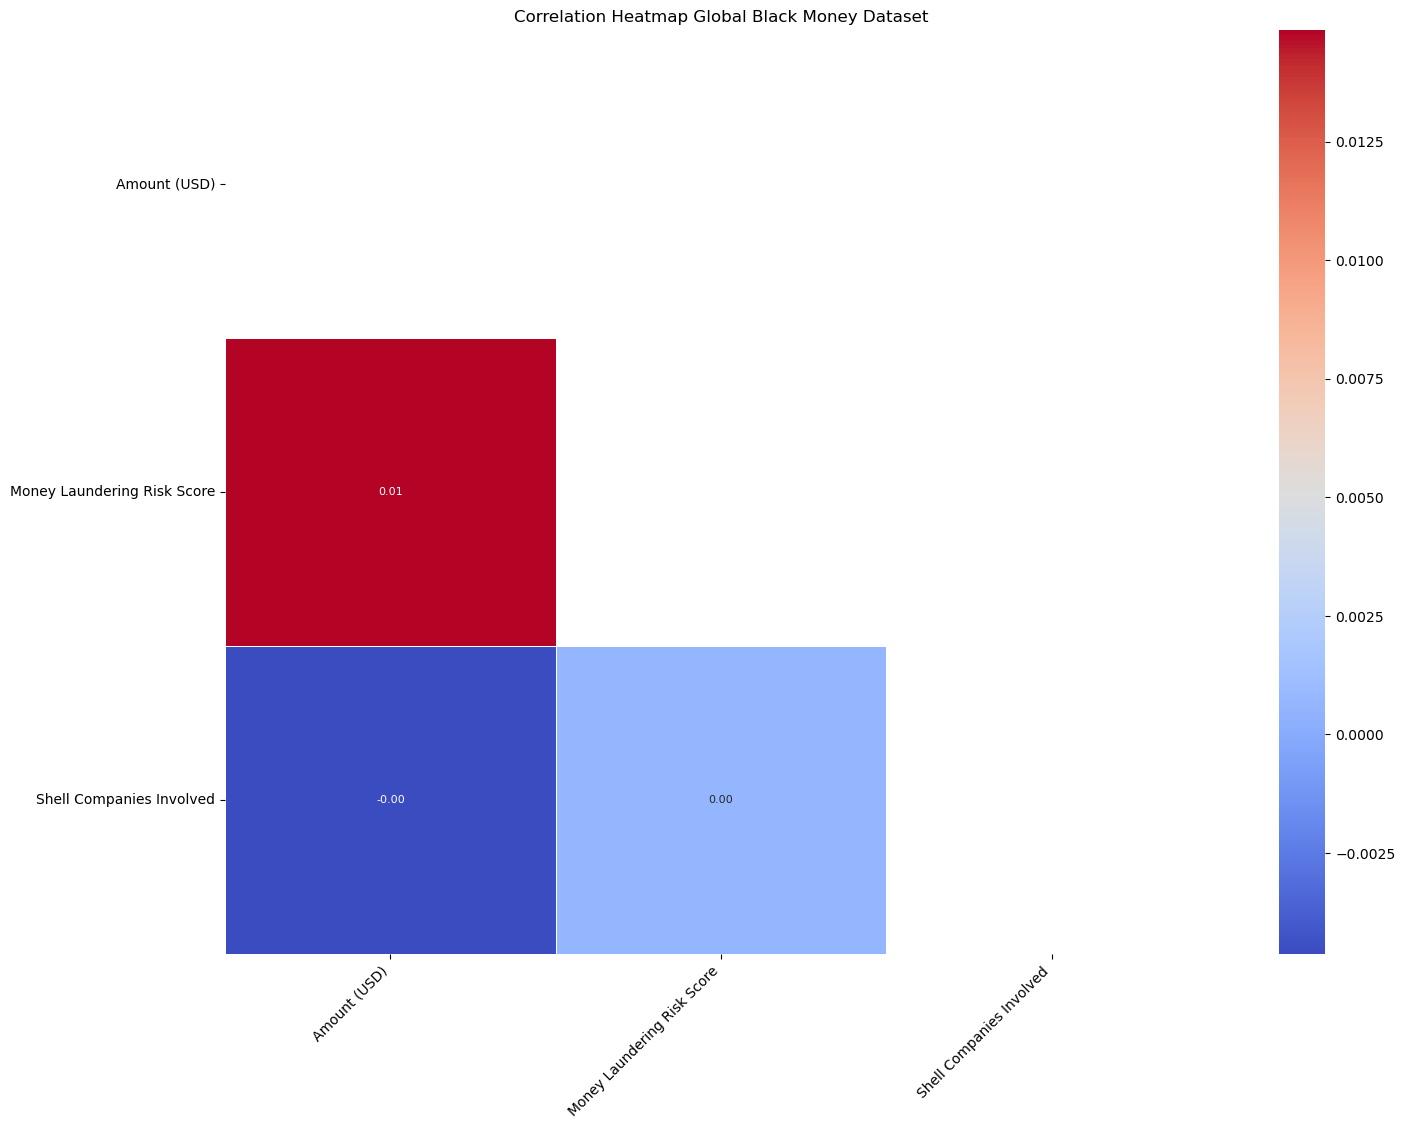

In [5]:
# Define Numeric Variables
numeric_predictors = ['Amount (USD)', 'Money Laundering Risk Score',  'Shell Companies Involved']

# Init Correlation Matrix
corr_matrix = df[numeric_predictors].corr()

# Create a heatmap
corr_matrix = corr_matrix

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap Global Black Money Dataset')

# Show the heatmap
plt.show()

### Distribution of illegal vs legal transactions

Source of Money
Legal      8983
Illegal    1017
Name: count, dtype: int64


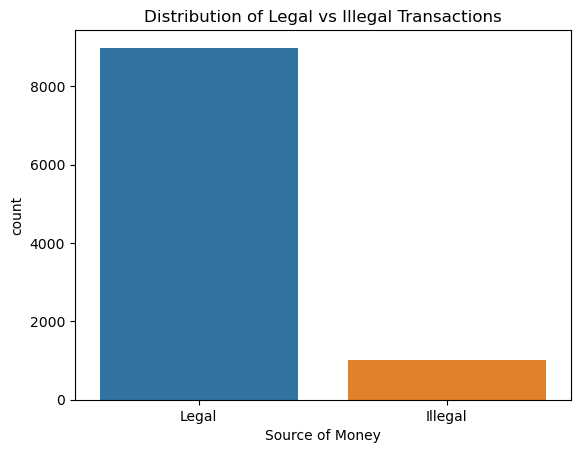

In [6]:
# Distribution of illegal vs legal transactions
print(df['Source of Money'].value_counts())

sns.countplot(x='Source of Money', data=df)
plt.title('Distribution of Legal vs Illegal Transactions')
plt.show()

### Distribution of illegal transactions by Industry

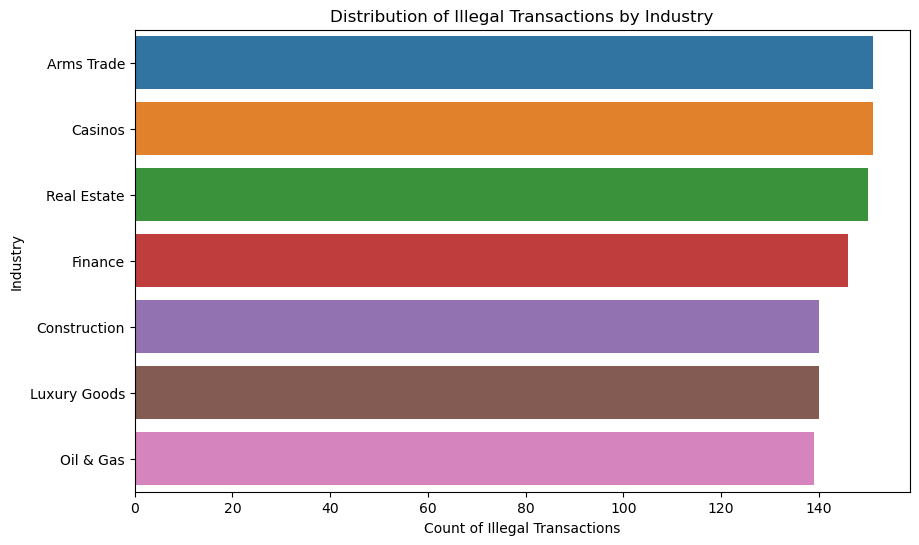

In [7]:
# Filter the dataset for illegal transactions
illegal_transactions = df[df['Source of Money'] == 'Illegal']

plt.figure(figsize=(10, 6))
sns.countplot(y='Industry', data=illegal_transactions, order=illegal_transactions['Industry'].value_counts().index)
plt.title('Distribution of Illegal Transactions by Industry')
plt.xlabel('Count of Illegal Transactions')
plt.ylabel('Industry')
plt.show()

In [8]:
print(illegal_transactions['Industry'].value_counts())  # Check if there are illegal transactions by industry

Industry
Arms Trade      151
Casinos         151
Real Estate     150
Finance         146
Construction    140
Luxury Goods    140
Oil & Gas       139
Name: count, dtype: int64


In [9]:
print(illegal_transactions.head())  # Show a sample of illegal transactions

# Check for missing values in the 'Industry' column
print(illegal_transactions['Industry'].isnull().sum())  # How many missing values in 'Industry'

# Check the distribution of values in the 'Industry' column
print(illegal_transactions['Industry'].value_counts())  # Check how many illegal transactions per industry

                     Country  Amount (USD)   Transaction Type  \
Transaction ID                                                  
TX0000000003              UK        319746    Stocks Transfer   
TX0000000010           China        305537  Offshore Transfer   
TX0000000019    South Africa         31263     Cryptocurrency   
TX0000000022             USA         64215  Property Purchase   
TX0000000053          Brazil        515486    Stocks Transfer   

               Date of Transaction Person Involved      Industry  \
Transaction ID                                                     
TX0000000003           1/1/13 2:00     Person_3655  Construction   
TX0000000010           1/1/13 9:00     Person_9585    Arms Trade   
TX0000000019          1/1/13 18:00     Person_2149  Luxury Goods   
TX0000000022          1/1/13 21:00     Person_6311     Oil & Gas   
TX0000000053           1/3/13 4:00     Person_3863  Construction   

               Destination Country  Reported by Authority Source of

### Distribution of overall transaction amount

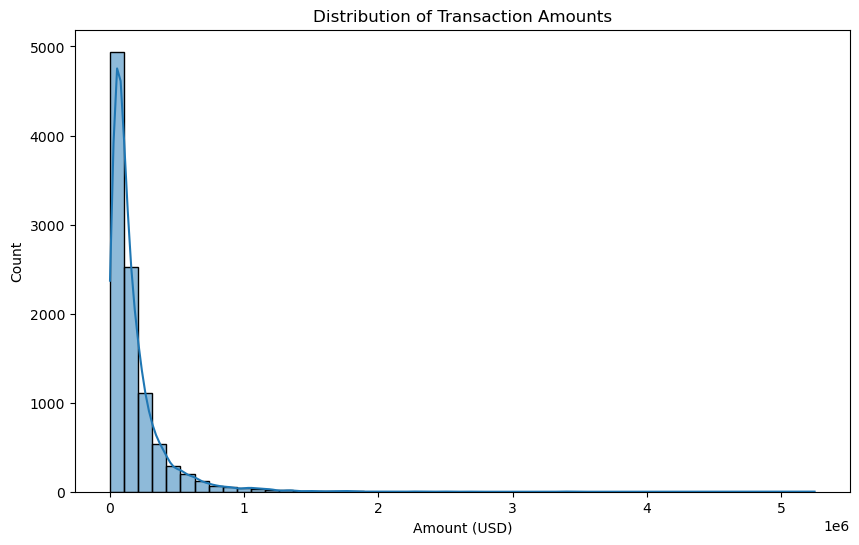

In [10]:
# Distribution of the overall transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount (USD)'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

### Transaction amount by source

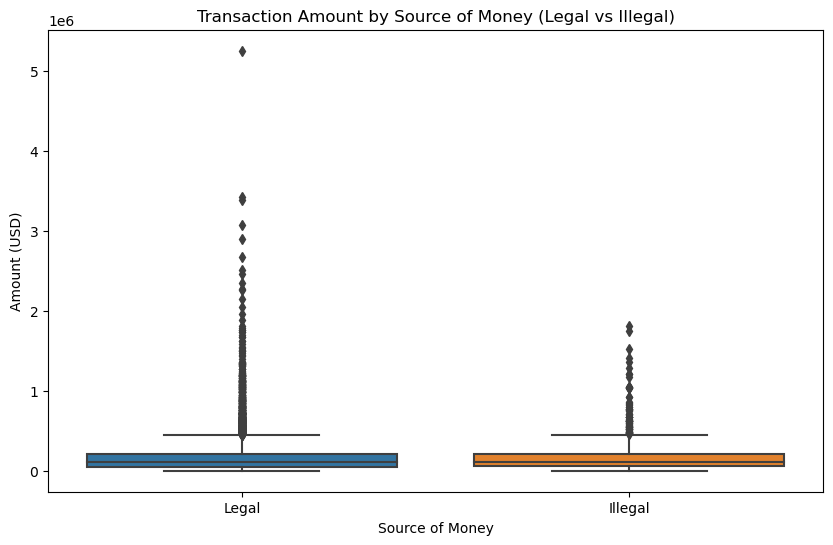

In [11]:
# Boxplot to compare Amount by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Amount (USD)', data=df)
plt.title('Transaction Amount by Source of Money (Legal vs Illegal)')
plt.show()

### Distribution of money laundering risk score

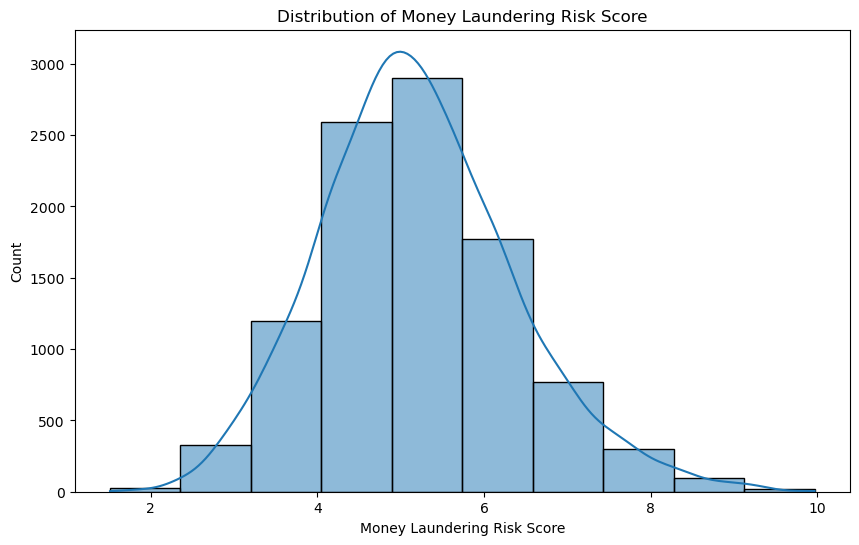

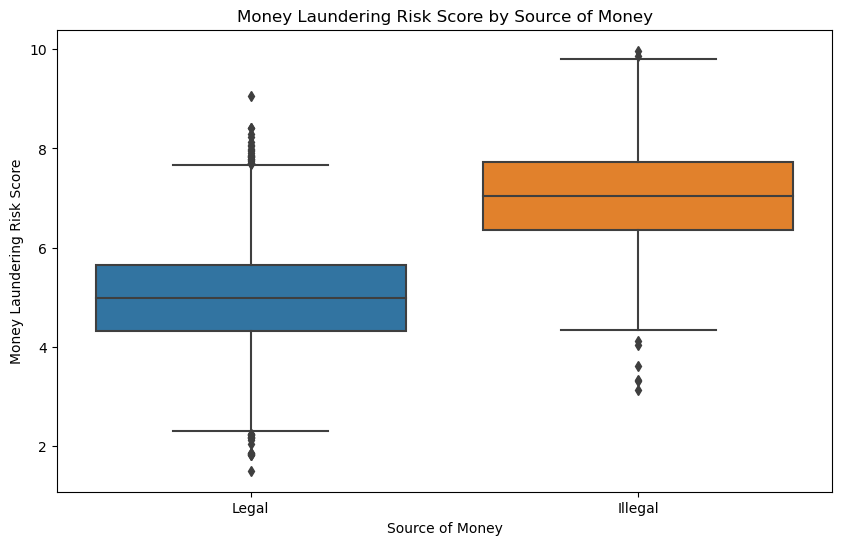

In [12]:
# Money Laundering Risk Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Money Laundering Risk Score'], bins=10, kde=True)
plt.title('Distribution of Money Laundering Risk Score')
plt.show()

# Boxplot to compare Risk Score by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Money Laundering Risk Score', data=df)
plt.title('Money Laundering Risk Score by Source of Money')
plt.show()

### Distribution of Illegal Transactions by Country

Country
Brazil          171
UAE             154
UK              144
Singapore        93
India            87
China            83
Russia           79
USA              75
Switzerland      68
South Africa     63
Name: count, dtype: int64


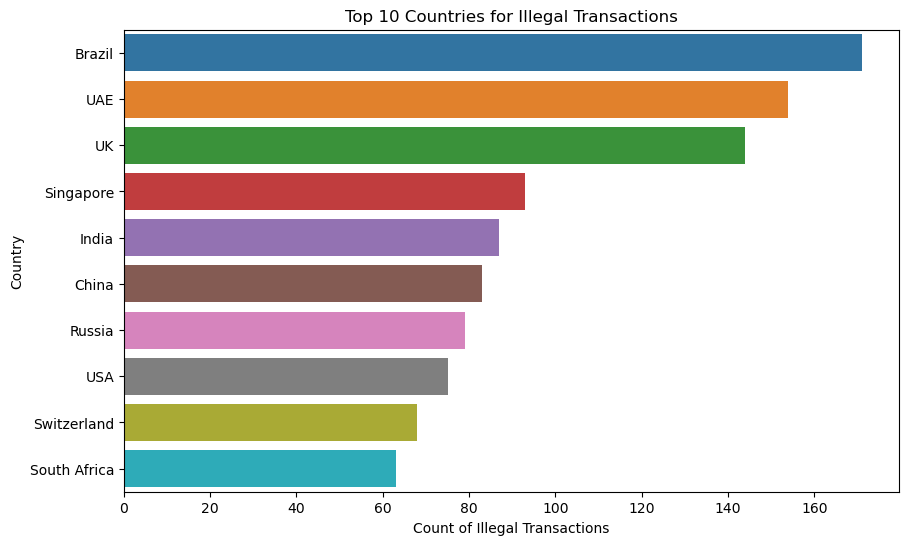

In [13]:
# Top countries for illegal transactions
illegal_countries = df[df['Source of Money'] == 'Illegal']['Country'].value_counts().head(10)
print(illegal_countries)

# top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x=illegal_countries.values, y=illegal_countries.index)
plt.title('Top 10 Countries for Illegal Transactions')
plt.xlabel('Count of Illegal Transactions')
plt.show()

## Data Preprocessing

In [14]:
# Convert 'Date of Transaction' to datetime
df['Date of Transaction'] = pd.to_datetime(df['Date of Transaction'])

# Convert datetime to seconds since epoch
df['Transaction_Seconds'] = (df['Date of Transaction'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Drop the old date column
df.drop(columns=['Date of Transaction'], inplace=True)

In [15]:
# Selecting categorical variables
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical Variables:', categorical_vars)

# Display unique values for categorical columns
for col in categorical_vars:
    print(f"{col}: {df[col].unique()}")

Categorical Variables: ['Country', 'Transaction Type', 'Person Involved', 'Industry', 'Destination Country', 'Source of Money', 'Financial Institution', 'Tax Haven Country']
Country: ['Brazil' 'China' 'UK' 'UAE' 'South Africa' 'Russia' 'Switzerland' 'India'
 'USA' 'Singapore']
Transaction Type: ['Offshore Transfer' 'Stocks Transfer' 'Cash Withdrawal' 'Cryptocurrency'
 'Property Purchase']
Person Involved: ['Person_1101' 'Person_7484' 'Person_3655' ... 'Person_6348' 'Person_4171'
 'Person_3267']
Industry: ['Construction' 'Luxury Goods' 'Oil & Gas' 'Real Estate' 'Arms Trade'
 'Casinos' 'Finance']
Destination Country: ['USA' 'South Africa' 'Switzerland' 'Russia' 'Brazil' 'UK' 'India' 'China'
 'Singapore' 'UAE']
Source of Money: ['Legal' 'Illegal']
Financial Institution: ['Bank_40' 'Bank_461' 'Bank_387' 'Bank_353' 'Bank_57' 'Bank_436'
 'Bank_452' 'Bank_88' 'Bank_87' 'Bank_404' 'Bank_273' 'Bank_252'
 'Bank_190' 'Bank_267' 'Bank_164' 'Bank_211' 'Bank_311' 'Bank_439'
 'Bank_50' 'Bank_337' 'Ba

In [16]:
# Convert 'Source of Money' to boolean (True for 'Illegal', False for 'Legal')
df['Source of Money'] = df['Source of Money'].map({'Illegal': True, 'Legal': False})

In [17]:
# Create dummy variables for categorical variables
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# new DataFrame with dummy variables
print(df_dummies.head())

                Amount (USD)  Reported by Authority  \
Transaction ID                                        
TX0000000001           70642                   True   
TX0000000002          308761                  False   
TX0000000003          319746                   True   
TX0000000004           55036                  False   
TX0000000005           50838                   True   

                Money Laundering Risk Score  Shell Companies Involved  \
Transaction ID                                                          
TX0000000001                       4.943966                         1   
TX0000000002                       5.217588                         0   
TX0000000003                       6.904060                         3   
TX0000000004                       6.102097                         2   
TX0000000005                       3.784610                         9   

                Transaction_Seconds  Country_China  Country_India  \
Transaction ID                   

In [18]:
# Check for missing data
print(df.isnull().sum())

# Drop rows with missing values if needed
df.dropna(inplace=True)

Country                        0
Amount (USD)                   0
Transaction Type               0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
Transaction_Seconds            0
dtype: int64


In [19]:
# Check for missing values in 'Person Involved'
print(df['Person Involved'].isnull().sum())

# Create df_clean by dropping rows with missing 'Person Involved'
df_clean = df.dropna(subset=['Person Involved'])

# Remove the 'Person_' prefix and convert the remainder to integers
df_clean['Person Involved'] = df_clean['Person Involved'].str.replace('Person_', '').astype(int)

# Verify the changes
print(df_clean['Person Involved'].head())

0
Transaction ID
TX0000000001    1101
TX0000000002    7484
TX0000000003    3655
TX0000000004    3226
TX0000000005    7975
Name: Person Involved, dtype: int64


In [20]:
# Use df_clean for features and ensure to select only numeric columns
X = df_dummies.loc[df_clean.index]  # Select only rows in df_clean

# Drop any non-numeric columns 
X_numeric = X.select_dtypes(include=[np.number])  # Keep only numeric columns

In [21]:
# Split the data
X = df_dummies.loc[df_clean.index]  # Use df_clean for consistent rows
y = df_clean['Source of Money']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Keep only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_numeric.loc[X_train.index])
X_test_scaled = scaler.transform(X_numeric.loc[X_test.index])

## Model Building Strategies

### Model 1: Logistic Regression

In [22]:
# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=2000, solver='liblinear')

# Fit model to scaled training data
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=2000, solver='liblinear')

In [23]:
# Make predictions on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.9275
Precision: 0.7500
Recall: 0.4286
F1 Score: 0.5455


#### Grid Search CV

In [24]:
# Define hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],  # Solvers for regularization
    'penalty': ['l1', 'l2']           # L1 or L2 regularization
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Re-train model with best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

#### Performance Metrics

In [25]:
# Make predictions with tuned model
y_pred_tuned = best_log_reg.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

# Save performance metrics to global Dict
performance_metrics = pd.DataFrame(data={
    'Accuracy': [accuracy_tuned, 0, 0],
    'Precision': [precision_tuned, 0, 0], 
    'Recall': [recall_tuned, 0, 0],
    'F1 Score': [f1_tuned, 0, 0]
}, index=['Logistic Regression', 'Random Forest', 'LightGBM'])

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.9280
Precision: 0.7521
Recall: 0.4335
F1 Score: 0.5500


#### Confusion Matrix

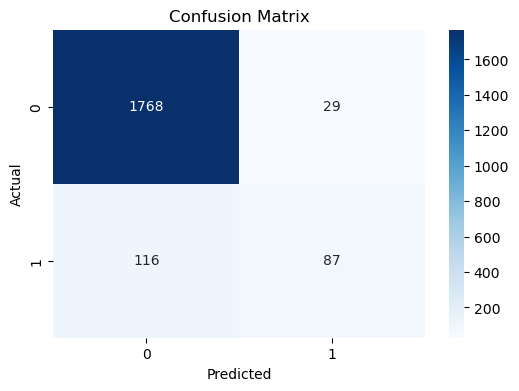

In [26]:
# Confusion Matrix
cm1 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Coefficients

In [27]:
# Get coefficients from logistic regression model
coefficients = log_reg.coef_[0]

# Ensure we use scaled features for DataFrame
X_numeric_columns = X_numeric.columns  #only numeric features

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_numeric_columns,
    'Coefficient': coefficients
})

# Sort DataFrame by coefficients
feature_importance.sort_values(by='Coefficient', ascending=False, inplace=True)
print(feature_importance)

                       Feature  Coefficient
1  Money Laundering Risk Score     2.369302
2     Shell Companies Involved     0.064767
3          Transaction_Seconds    -0.000317
0                 Amount (USD)    -0.043253


In [28]:
# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

Cross-Validation F1 Scores: [0.58267717 0.61538462 0.578125   0.6        0.60583942]
Mean F1 Score: 0.5964


#### ROC Curve

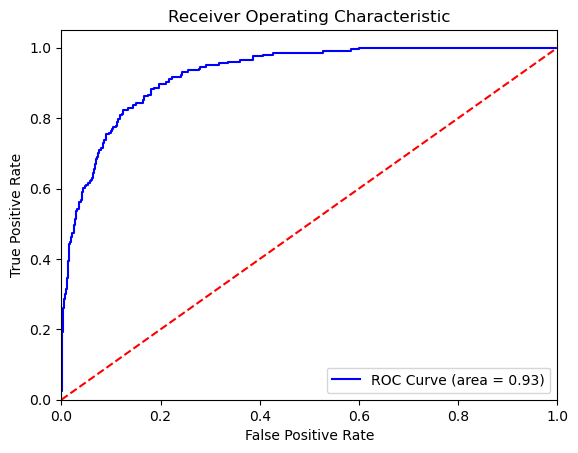

In [29]:
# Get predicted probabilities
y_scores = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 2: Random Forest Classifier

In [30]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit model to scaled training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.9195
Precision: 0.9090
Recall: 0.9195
F1 Score: 0.9106


#### Grid Search CV

In [31]:
# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Results
# Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}


#### Performance Metrics

In [32]:
# Re-train model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions with tuned model
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

# Save metrics to global metrics grid
performance_metrics.at['Random Forest', 'Accuracy'] = accuracy_tuned
performance_metrics.at['Random Forest', 'Precision'] = precision_tuned
performance_metrics.at['Random Forest', 'Recall'] = recall_tuned
performance_metrics.at['Random Forest', 'F1 Score'] = f1_tuned

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.9225
Precision: 0.9127
Recall: 0.9225
F1 Score: 0.9134


#### Confusion Matrix

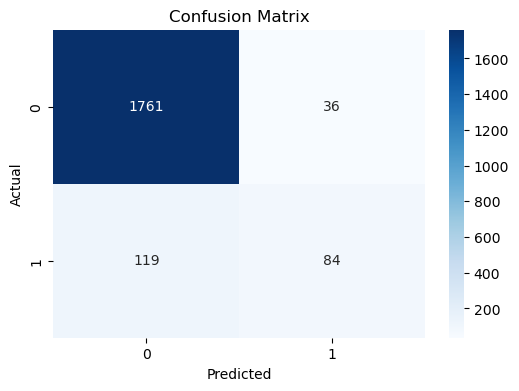

In [33]:
# Confusion Matrix
cm2 = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [34]:
# Get feature importances from the Random Forest model
importance = best_rf_model.feature_importances_

X_numeric_columns = X_numeric.columns  # Numeric features from your dataset

# Create feature importance DataFrame based on Random Forest feature importances
feature_importance = pd.DataFrame({
    'Feature': X_numeric_columns,
    'Importance': importance
})

# Sort DataFrame by feature importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance)

                       Feature  Importance
1  Money Laundering Risk Score    0.793900
0                 Amount (USD)    0.093469
3          Transaction_Seconds    0.087176
2     Shell Companies Involved    0.025456


In [35]:
# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

# Get predicted probabilities
y_scores = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

Cross-Validation F1 Scores: [0.56704981 0.60283688 0.56060606 0.58955224 0.61313869]
Mean F1 Score: 0.5866


#### ROC Curve

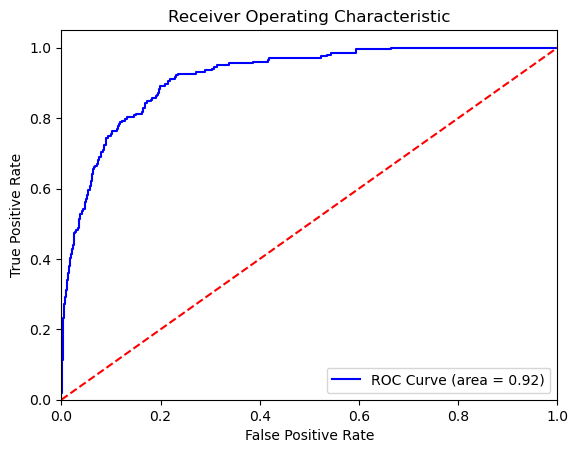

In [36]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model 3: LightGBM

#### Grid Search CV

In [37]:
# initialize LightGBM
lgb_model = lgb.LGBMClassifier(class_weight='balanced', verbose=-1)

# define model parameters
# param_grid = {
#     'num_leaves': [31, 50, 100, 200],
#     'learning_rate': [0.001, 0.01, 0.1], 
#     'n_estimators': [10, 100, 1000],
#     'min_data_in_leaf': [20, 40, 80]
# }
#
# Results of GridSearch Phase 1
# Best Hyperparameters: {'learning_rate': 0.1, 'min_data_in_leaf': 20, 'n_estimators': 10, 'num_leaves': 31}

param_grid = {
    'num_leaves': [31],                      # Leaf nodes in trees (higher means more complex model)
    'max_depth': [5, 10],                    # -1 for no limit on depth, or values to control depth
    'learning_rate': [0.1],                  # Smaller values can be better but require more trees
    'n_estimators': [200],                   # Number of trees/boosting iterations
    'min_child_samples': [50],               # Minimum number of samples in a leaf node
    'min_data_in_leaf': [20],                # Minimal number of data in one leaf
    'subsample': [0.6, 0.9],                 # Fraction of data to train each tree (bagging)
    'colsample_bytree': [0.6, 0.8, 1.0],     # Fraction of features to train each tree
    'lambda_l1': [0, 0.1],                   # L1 regularization
    'lambda_l2': [0, 0.1],                   # L2 regularization
}

# 5-fold cross-validation
grid_search = GridSearchCV(estimator=lgb_model, 
   param_grid=param_grid, 
   scoring='f1', 
   cv=5,  
   verbose=0,
   n_jobs=-1) 

# fit the model
grid_search.fit(X_train_scaled, y_train)

# utilize the best model found by grid_search
best_lgb_model = grid_search.best_estimator_

# make predictions on test data
y_pred_proba = best_lgb_model.predict(X_test_scaled)

# convert probabilities to binary values
y_pred = [1 if x >= 0.5 else 0 for x in y_pred_proba]

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'colsample_bytree': 1.0, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 50, 'min_data_in_leaf': 20, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.6}
Best Score: 0.580226092105488


#### Confusion Matrix

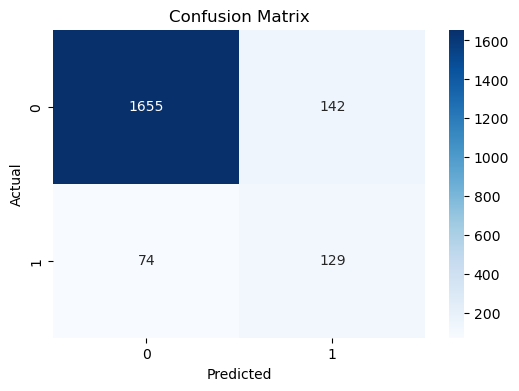

In [38]:
# Confusion Matrix
cm3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Performance Metrics

In [39]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Save metrics to global metrics grid
performance_metrics.at['LightGBM', 'Accuracy'] = accuracy
performance_metrics.at['LightGBM', 'Precision'] = precision
performance_metrics.at['LightGBM', 'Recall'] = recall
performance_metrics.at['LightGBM', 'F1 Score'] = f1

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.8920
Precision: 0.4760
Recall: 0.6355
F1 Score: 0.5443


#### ROC Curve

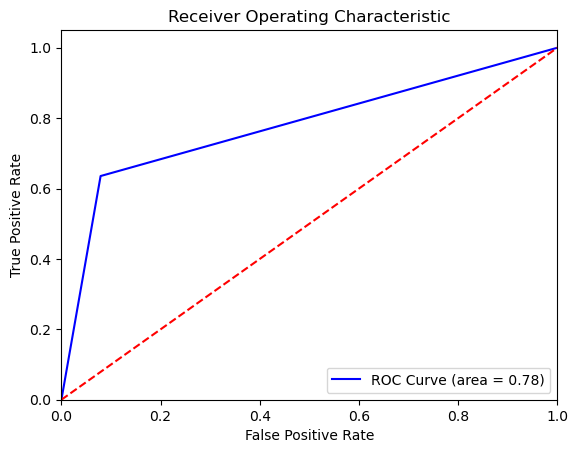

In [40]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation

In [41]:
# display all models' performance
performance_metrics

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.9280,0.752137,0.433498,0.550000
Random Forest,0.9225,0.912677,0.922500,0.913417
LightGBM,0.8920,0.476015,0.635468,0.544304


In [42]:
# confusion matrix (Logistic Regression)
print('confusion matrix (Logistic Regression)')
print(cm1)
print()

# confusion matrix (Random Forest)
print('confusion matrix (Random Forest Classifier)')
print(cm2)
print()

# confusion matrix (LightGBM)
print('confusion matrix (LightGBM Classifier)')
print(cm3)

confusion matrix (Logistic Regression)
[[1768   29]
 [ 116   87]]

confusion matrix (Random Forest Classifier)
[[1761   36]
 [ 119   84]]

confusion matrix (LightGBM Classifier)
[[1655  142]
 [  74  129]]


## Final Model Selection

Random Forest Classifier (RFC) was found to be the most performant in predicting whether a transaction originated from illicit sources. It boasted a high accuracy (.9225), precision (.9127), and recall (.9225). While the Logistic Regression model boasted a slightly higher accuracy (.9280), it was signifantly worse in terms of precision (.7521) and recall (.4335). The LightGBM Classifier struggled as well with relatively low accuracy (.8920), precision (.4760), and recall (.6355).

When comparing the models by F1 Score and ROC-AUC, RFC had the highest F1 Score (.9134) and a high ROC-AUC (.92). Due to RFC having the highest F1 score of the three models and a well-profiled ROC curve, it was selected as the most suitable for production usage.

## Discussion and Conclusion

In response to the political and regulatory pressure to address the increase in the transit of money originating from illegal sources, aka "dirty money," The Good Bank Inc. aimed to build a classification model that could accurately predict at least 90% of all illegal transactions. These transactions marked as "dirty" would them be sent for further human inspection by our auditing team as well as the relevant government entities. To accomplish this, several models were evaluated including Logistic Regression, Random Forest Classifier, and LightGBM Classifier. Of these models, the Random Forest Classification model performed the best in terms of identifying dirty transactions. Further details of its implementation and evaluation are discussed below.

The dataset consisting of 10,000 transaction records was split into a training and test partitions with a split of 80/20% respectively. Categorical variables were one-hot encoded and numeric variables were standardized. The Random Forest Classifier was then tuned using a Grid Search, 5-fold Cross Validation strategy. The results of which helped us tune the model's yperparameters as follows: 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, and 'n_estimators': 50. Overall, it performed well with high accuracy, precision, recall, and a comparitively strong F1 Score. It's ability to identify the "dirty" transactions met our objective of at least 90%, with a precision score of 91.27%.  

While we recommend utilizing the current iteration of this Random Forest Classification model for production usage, further research should be allocated quarterly to retrain the model using fresh data so that new patterns in dirty transactions are accounted for in the production model. This will ensure that the company will remain in compliance with regulators as well as reaffirm its commitment to protecting both its shareholders and customers alike.